In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random

print('All libraries loaded successfully.')

All libraries loaded successfully.


---
## Question 1 – Line Fitting with Total Least Squares and RANSAC

### Load Dataset

In [18]:
# Load lines.csv
D = np.genfromtxt('../assets/lines.csv', delimiter=',', skip_header=1)

print('Dataset shape:', D.shape)
print('First 5 rows:')
print(D[:5])

# Column layout: x1, x2, x3, y1, y2, y3
X_cols = D[:, :3]
Y_cols = D[:, 3:]

# Flatten all points for Q1(b)
X_all = X_cols.flatten()
Y_all = Y_cols.flatten()

Dataset shape: (100, 6)
First 5 rows:
[[ -5.30547099  -4.06009155  -5.26129006 -12.66633342  -3.79615021
    3.69171161]
 [ -5.5403588   -5.0031803   -3.99259187 -11.00772693  -3.98562503
    4.90000402]
 [ -4.98212753  -4.58449362  -4.33122591 -11.69731474  -3.58927699
    5.04686274]
 [ -4.49570614  -5.06413838  -4.78201809 -11.97801037  -3.59707103
    4.63593624]
 [ -4.44215386  -4.41137023  -4.5675092  -12.41495176  -2.79950409
    4.73969871]]


### Q1(a) – Total Least Squares (TLS) on Line 1 Data

Total Least Squares minimises perpendicular distances from points to a line.  
For a line $ax + by + c = 0$ (with $a^2 + b^2 = 1$), the normal $(a, b)$ is the left singular vector corresponding to the **smallest** singular value of the mean-centred data matrix.

In [19]:
def total_least_squares(x, y):
    # Centre the data
    x_mean, y_mean = np.mean(x), np.mean(y)
    A = np.column_stack([x - x_mean, y - y_mean])

    # SVD – the normal direction is the right singular vector for the smallest singular value
    _, _, Vt = np.linalg.svd(A)
    a, b = Vt[-1]   # last row = smallest singular value direction

    # c from the centroid condition: a*x_mean + b*y_mean + c = 0
    c = -(a * x_mean + b * y_mean)
    return a, b, c


# Use only x1, y1 (first line data)
x1 = D[:, 0]
y1 = D[:, 3]

a1, b1, c1 = total_least_squares(x1, y1)
print('TLS parameters for Line 1:')
print(f'  a = {a1:.6f}')
print(f'  b = {b1:.6f}')
print(f'  c = {c1:.6f}')
print(f'  Line equation: {a1:.4f}x + {b1:.4f}y + {c1:.4f} = 0')

# Slope-intercept form: y = m*x + k  (if b != 0)
if abs(b1) > 1e-9:
    m1 = -a1 / b1
    k1 = -c1 / b1
    print(f'  Slope-intercept: y = {m1:.4f}x + {k1:.4f}')

TLS parameters for Line 1:
  a = 0.773562
  b = -0.633721
  c = -3.794192
  Line equation: 0.7736x + -0.6337y + -3.7942 = 0
  Slope-intercept: y = 1.2207x + -5.9872


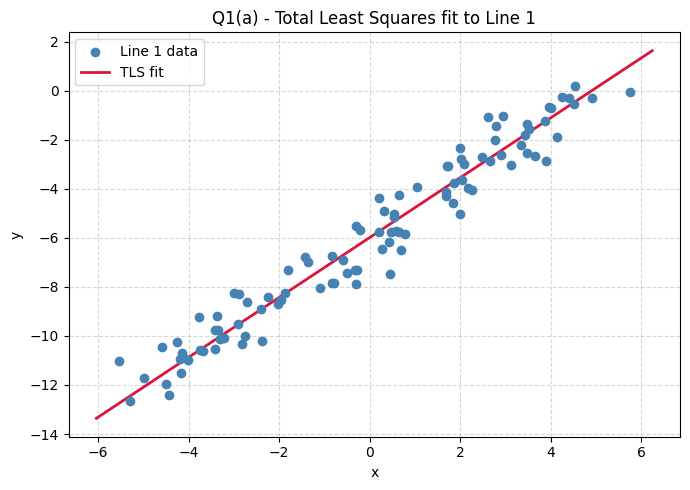

In [20]:
# Visualise Line 1 TLS fit
x_plot = np.linspace(x1.min() - 0.5, x1.max() + 0.5, 200)
y_plot = m1 * x_plot + k1

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x1, y1, color='steelblue', label='Line 1 data', zorder=3)
ax.plot(x_plot, y_plot, color='crimson', linewidth=2, label='TLS fit')
ax.set_title('Q1(a) - Total Least Squares fit to Line 1')
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.legend(); ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('../results/q1a_tls_line1.png', dpi=150)
plt.show()

### Q1(b) – RANSAC to find Three Lines from All Data

**Algorithm:**
1. Randomly sample 2 points → fit a line (TLS on 2 points = exact).
2. Count inliers (perpendicular distance < threshold).
3. Repeat and keep the hypothesis with the most inliers.
4. Refit TLS on all inliers → consensus set.
5. Mask the consensus and repeat for the next line.

In [21]:
def point_to_line_distance(x, y, a, b, c):
    return np.abs(a * x + b * y + c) / np.sqrt(a**2 + b**2)


def ransac_fit_line(x, y, n_iter=1000, threshold=0.5, min_inliers=10):
    best_mask = np.zeros(len(x), dtype=bool)
    best_count = 0
    best_params = None

    n = len(x)
    for _ in range(n_iter):
        # Minimal sample: 2 points
        idx = random.sample(range(n), 2)
        xs, ys = x[idx], y[idx]

        # Fit TLS to 2 points (direction vector)
        dx = xs[1] - xs[0]
        dy = ys[1] - ys[0]
        norm = np.sqrt(dx**2 + dy**2)
        if norm < 1e-9:
            continue
        a = -dy / norm
        b =  dx / norm
        c = -(a * xs[0] + b * ys[0])

        # Inlier mask
        dist = point_to_line_distance(x, y, a, b, c)
        mask = dist < threshold
        count = np.sum(mask)

        if count > best_count:
            best_count = count
            best_mask = mask
            best_params = (a, b, c)

    if best_params is None or best_count < min_inliers:
        return None, None

    # Refit TLS on all inliers
    a_ref, b_ref, c_ref = total_least_squares(x[best_mask], y[best_mask])
    # Recompute mask with refined params
    dist_ref = point_to_line_distance(x, y, a_ref, b_ref, c_ref)
    final_mask = dist_ref < threshold

    return (a_ref, b_ref, c_ref), final_mask


# ---- Run RANSAC three times, masking each consensus set ----
x_rem = X_all.copy()
y_rem = Y_all.copy()
active = np.ones(len(X_all), dtype=bool)

lines = []
masks = []
colors = ['crimson', 'forestgreen', 'royalblue']

random.seed(42)
np.random.seed(42)

for i in range(3):
    x_cur = X_all[active]
    y_cur = Y_all[active]

    params, mask_local = ransac_fit_line(x_cur, y_cur, n_iter=2000, threshold=0.4)

    if params is None:
        print(f'RANSAC failed to find line {i+1}')
        break

    a, b, c = params
    print(f'Line {i+1}: a={a:.6f}, b={b:.6f}, c={c:.6f}')
    if abs(b) > 1e-9:
        m = -a/b; k = -c/b
        print(f'         y = {m:.4f}x + {k:.4f}  |  inliers = {np.sum(mask_local)}')

    # Store global indices
    global_idx = np.where(active)[0]
    inlier_global = global_idx[mask_local]

    lines.append(params)
    masks.append(inlier_global)

    # Mask out the consensus set
    active[inlier_global] = False

print(f'\nRemaining unclassified points: {np.sum(active)}')

Line 1: a=-0.445405, b=-0.895329, c=1.804913
         y = -0.4975x + 2.0159  |  inliers = 69
Line 2: a=0.718067, b=-0.695974, c=0.728210
         y = 1.0317x + 1.0463  |  inliers = 56
Line 3: a=0.784311, b=-0.620368, c=-3.613804
         y = 1.2643x + -5.8253  |  inliers = 57

Remaining unclassified points: 118


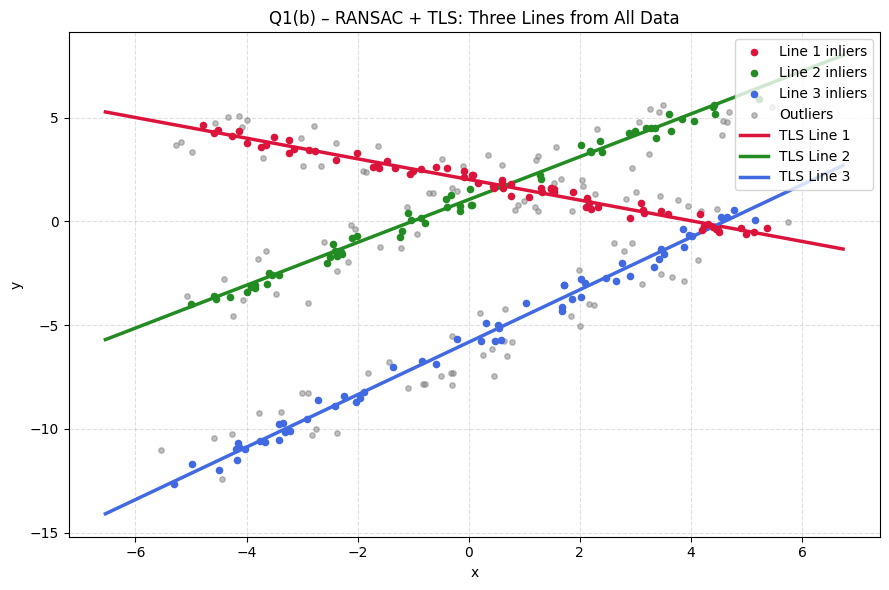

In [22]:
# Visualise all three lines
fig, ax = plt.subplots(figsize=(9, 6))

# Plot inliers for each line
for i, (params, idx, col) in enumerate(zip(lines, masks, colors)):
    ax.scatter(X_all[idx], Y_all[idx], color=col, s=20, label=f'Line {i+1} inliers', zorder=3)

# Plot outliers
outlier_mask = np.ones(len(X_all), dtype=bool)
for idx in masks:
    outlier_mask[idx] = False
ax.scatter(X_all[outlier_mask], Y_all[outlier_mask], color='gray', s=15,
           alpha=0.5, label='Outliers', zorder=2)

# Draw fitted lines
x_range = np.linspace(X_all.min() - 1, X_all.max() + 1, 300)
for i, (params, col) in enumerate(zip(lines, colors)):
    a, b, c = params
    if abs(b) > 1e-9:
        y_line = (-a * x_range - c) / b
        ax.plot(x_range, y_line, color=col, linewidth=2.5, label=f'TLS Line {i+1}')

ax.set_title('Q1(b) – RANSAC + TLS: Three Lines from All Data')
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.legend(loc='upper right'); ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('../results/q1b_ransac_3lines.png', dpi=150)
plt.show()